# Contents
- [ModelGoals](#1.0-Project:-Stroke-Prediction-Model)
- [EDA](#2.0-Data-Organization-and-Exploration)
- [Data Cleaning](#3.0-Data-Cleaning-and-Manipulation)
- [Modeling](#4.0-Data-Modeling)
- [Final Model](#5.0-Final-Model)
- [Model Deployment](#6.0-Model-Deployment)

# 1.0 Project: Stroke Prediction Model

The goal of this model is to predicts whether a patient has a stroke or not using information available about the patient.
Optimal model should deliver camparatively better predictions over peer models by performing better over both positive and negetive stroke case predictions to ensure higher trust in proposed use case as an stroke early warning predictive model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, matthews_corrcoef

from collections import Counter
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE


## 2.0 Data Organization and Exploration
[top](#Contents)

In [3]:
rng_val = 42
stroke_df = pd.read_csv("data/stroke_data.csv")
#sns.set_theme(style="whitegrid")

In [4]:
stroke_df.shape[0]

5110

In [5]:
#Split the dataset into training and test
stroke_train_df,stroke_test_val_df = train_test_split(stroke_df, test_size=0.30, stratify=stroke_df[["stroke"]], random_state=rng_val)

In [6]:
#Further split test dataset into a validation dataset and a test dataset to be used for final model evaluation
stroke_val_df,stroke_test_df = train_test_split(stroke_test_val_df, test_size=0.50, stratify=stroke_test_val_df[["stroke"]], random_state=rng_val)

In [7]:
print(f"dimension for training dataset is: \
{stroke_train_df.shape} with target statistics {Counter(stroke_train_df['stroke'])}")

print(f"dimension for the test dataset for final model validatation is \
{stroke_test_df.shape} with target statistics {Counter(stroke_test_df['stroke'])}")

dimension for training dataset is: (3577, 12) with target statistics Counter({0: 3403, 1: 174})
dimension for the test dataset for final model validatation is (767, 12) with target statistics Counter({0: 729, 1: 38})


In [8]:
stroke_train_full = stroke_train_df.copy(deep = True)

In [9]:
print(stroke_train_full.shape)

(3577, 12)


In [10]:
stroke_train_full.head().T

,2226,3927,3358,4152,4866
id,35602,56137,14063,12857,5875
gender,Female,Female,Male,Male,Female
age,52.0,62.0,81.0,55.0,37.0
hypertension,0,0,0,0,0
heart_disease,0,0,1,0,0
ever_married,Yes,Yes,No,Yes,Yes
work_type,Govt_job,Private,Self-employed,Self-employed,Private
Residence_type,Rural,Urban,Rural,Rural,Urban
avg_glucose_level,107.84,88.32,95.49,73.57,103.66
bmi,22.0,36.3,29.4,28.0,36.1


In [11]:
stroke_train_full = stroke_train_full.drop('id', axis=1) #remove the id column, a string identifier
print(stroke_train_full.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3577 entries, 2226 to 5052
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3577 non-null   object 
 1   age                3577 non-null   float64
 2   hypertension       3577 non-null   int64  
 3   heart_disease      3577 non-null   int64  
 4   ever_married       3577 non-null   object 
 5   work_type          3577 non-null   object 
 6   Residence_type     3577 non-null   object 
 7   avg_glucose_level  3577 non-null   float64
 8   bmi                3429 non-null   float64
 9   smoking_status     3577 non-null   object 
 10  stroke             3577 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 335.3+ KB
None


<Axes: >

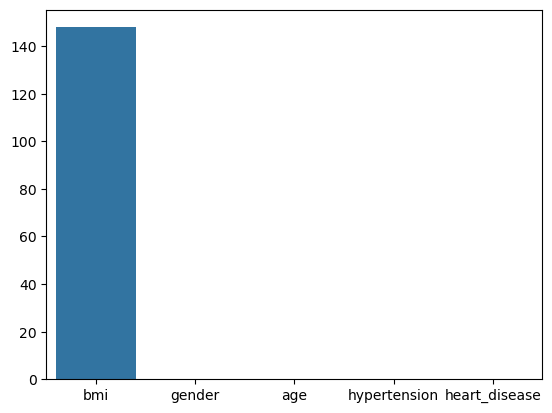

In [12]:
test = stroke_train_full.isna().sum()
test = test.sort_values(ascending=False).head(5)
sns.barplot(x=test.index, y=test.values)

In [13]:
print(test)

bmi              148
gender             0
age                0
hypertension       0
heart_disease      0
dtype: int64


In [14]:
stroke_train_full['stroke'].value_counts(normalize=True)

stroke
0    0.951356
1    0.048644
Name: proportion, dtype: float64

In [15]:
stroke_train_full['hypertension'].value_counts()

hypertension
0    3233
1     344
Name: count, dtype: int64

In [16]:
stroke_train_full['gender'].value_counts()

gender
Female    2093
Male      1483
Other        1
Name: count, dtype: int64

In [17]:
stroke_train_full['Residence_type'].value_counts()

Residence_type
Urban    1803
Rural    1774
Name: count, dtype: int64

In [18]:
stroke_train_full['ever_married'].value_counts(normalize=True)

ever_married
Yes    0.66005
No     0.33995
Name: proportion, dtype: float64

In [19]:
def get_the_data_types(dframe, desired_type):
    """Returns a columns in a dataframe based on the desired data types provided"""
    subset_df = dframe.select_dtypes(include=desired_type)
    type_needed = list(subset_df.columns)
    return type_needed

In [20]:
categorical = get_the_data_types(stroke_train_full,["category", "object"])

In [21]:
numerics = get_the_data_types(stroke_train_full,["int","float"])

In [22]:
only_numeric_df = stroke_train_full[numerics]

In [23]:
stroke_train_full[categorical].nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [24]:
stroke_train_full['work_type'].value_counts(normalize=True)

work_type
Private          0.571429
Self-employed    0.164663
children         0.134470
Govt_job         0.126083
Never_worked     0.003355
Name: proportion, dtype: float64

In [25]:
stroke_train_full['smoking_status'].value_counts(normalize=True)

smoking_status
never smoked       0.370981
Unknown            0.303047
formerly smoked    0.176405
smokes             0.149567
Name: proportion, dtype: float64

In [26]:
temp = stroke_train_full.select_dtypes(include="int")
temp.apply(pd.Series.value_counts).fillna('N/A')

,hypertension,heart_disease,stroke
0,3233,3384,3403
1,344,193,174


In [27]:
only_category_df = stroke_train_full.select_dtypes(include="object")
only_category_df = only_category_df.drop(['gender', 'Residence_type', 'ever_married'], axis = 1)
only_category_df.apply(pd.Series.value_counts).fillna('N/A')

,work_type,smoking_status
Govt_job,451.0,N/A
Never_worked,12.0,N/A
Private,2044.0,N/A
Self-employed,589.0,N/A
Unknown,N/A,1084.0
children,481.0,N/A
formerly smoked,N/A,631.0
never smoked,N/A,1327.0
smokes,N/A,535.0


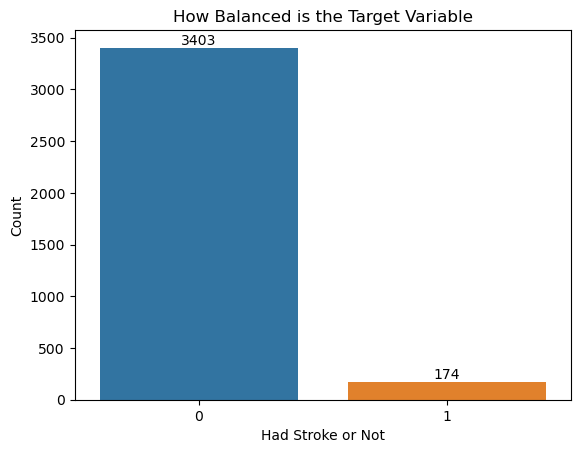

In [28]:
target_plot = sns.countplot(data=stroke_train_full, x="stroke")
for label in target_plot.containers:
    target_plot.bar_label(label)
target_plot.set_title('How Balanced is the Target Variable')
target_plot.set_xlabel('Had Stroke or Not')
target_plot.set_ylabel('Count')
plt.show()

<Axes: xlabel='age', ylabel='Count'>

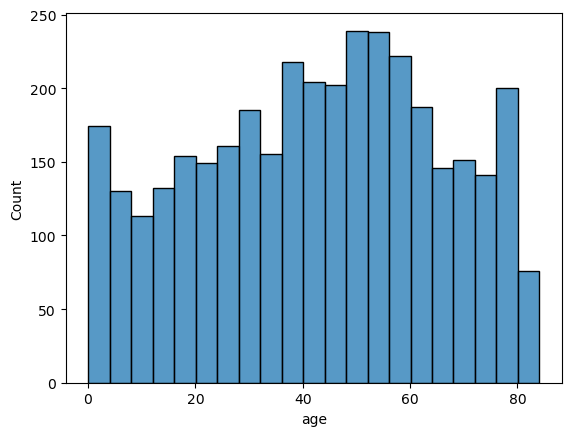

In [29]:
sns.histplot(data=stroke_train_full, x='age', binwidth=4)

In [30]:
only_numeric_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3577.000000,3577.000000,3577.000000,3577.000000,3429.000000,3577.000000
mean,43.250433,0.096170,0.053956,105.957414,28.867279,0.048644
std,22.493077,0.294865,0.225962,44.945203,7.909601,0.215153
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.460000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.710000,28.000000,0.000000
75%,61.000000,0.000000,0.000000,113.630000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [31]:
only_numeric_df["stroke"].value_counts(normalize=True)

stroke
0    0.951356
1    0.048644
Name: proportion, dtype: float64

In [32]:
only_numeric_df["bmi"].isnull().sum()

148

<Axes: xlabel='avg_glucose_level', ylabel='Density'>

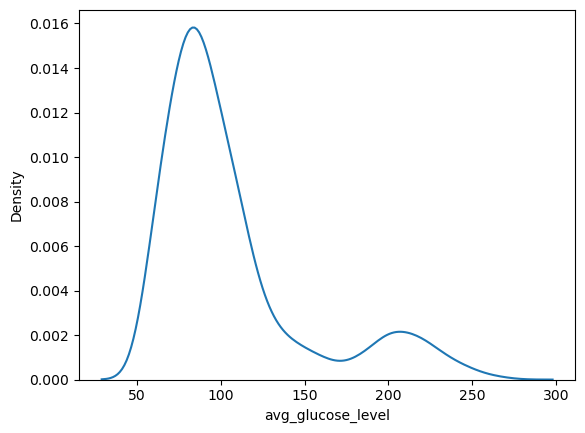

In [33]:
sns.kdeplot(data=stroke_train_full, x="avg_glucose_level")

<Axes: xlabel='bmi', ylabel='Density'>

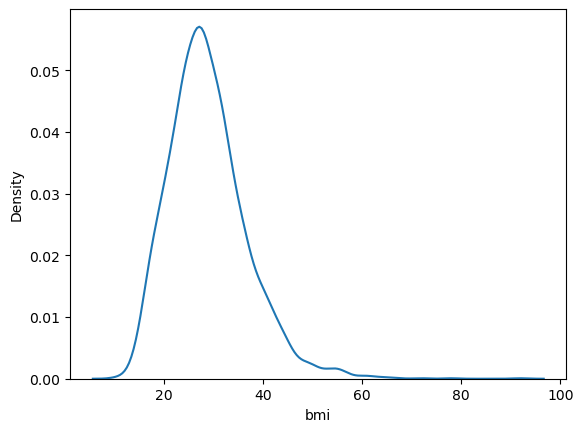

In [34]:
sns.kdeplot(data=stroke_train_full, x="bmi")

<Axes: xlabel='age', ylabel='Density'>

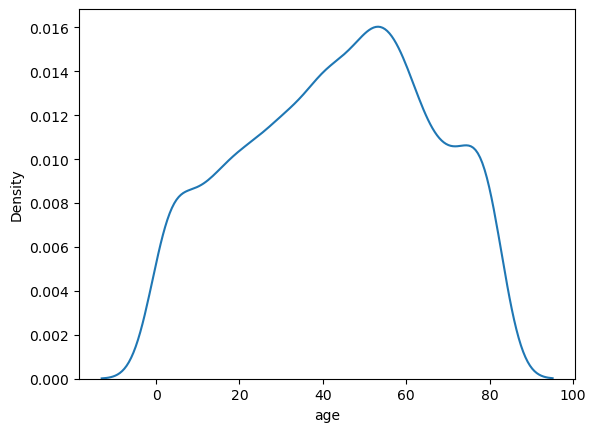

In [35]:
sns.kdeplot(data=stroke_train_full, x="age")

### 3.0 Data Cleaning and Manipulation
[top](#Contents)

In [36]:
def clean_formatting(dframe):
    """ Standardizes the formating for column names and remove spaces within row elements
        The columns to be formatted are hard coded in the function"""
    dframe.columns = dframe.columns.str.lower().str.replace(' ', '_')
    dframe["work_type"] = dframe["work_type"].str.replace(' ', '_')
    dframe["work_type"] = dframe["work_type"].str.capitalize()
    dframe["smoking_status"] = dframe["smoking_status"].str.replace(' ', '_')
    dframe["smoking_status"] = dframe["smoking_status"].str.capitalize()
    return dframe

In [37]:
dev_stage = ["Childhood", "Adolescence", "Young_adult", "Middle_age", "Elderly"]
age_bin = [-np.inf, 12, 18, 40, 65, np.inf]

glucose_ranges = ["Hypo", "Normal", "Hyper"]
glucose_bin = [-np.inf, 70.0, 150.0, np.inf]

bmi_ranges = ["Emaciated", "Midway", "Obese"]
bmi_bin = [-np.inf, 16.5, 35.0, np.inf]

def gen_features(dframe):
    """ Create additional features for age groups and glucose from pre-defined bins"""
    dframe["age_status"] = pd.cut(dframe["age"], bins=age_bin, labels=dev_stage)
    dframe["glucose_range"] = pd.cut(dframe["avg_glucose_level"], bins=glucose_bin, labels=glucose_ranges)
    return dframe

In [38]:
def resolve_missing_bmi(dframe):
        """ Imputes values for missing data """
        dframe["bmi"] = dframe["bmi"].fillna(dframe.groupby("age_status")["bmi"].transform(lambda x: x.median()))
        dframe["bmi_range"] = pd.cut(dframe["bmi"], bins=bmi_bin, labels=bmi_ranges)

In [39]:
only_category_df = stroke_train_full.select_dtypes(include=["object", "category"])
categorical = list(only_category_df.columns)
numerics = ["age", "avg_glucose_level", "bmi"]

In [40]:
stroke_train_full.head().T

,2226,3927,3358,4152,4866
gender,Female,Female,Male,Male,Female
age,52.0,62.0,81.0,55.0,37.0
hypertension,0,0,0,0,0
heart_disease,0,0,1,0,0
ever_married,Yes,Yes,No,Yes,Yes
work_type,Govt_job,Private,Self-employed,Self-employed,Private
Residence_type,Rural,Urban,Rural,Rural,Urban
avg_glucose_level,107.84,88.32,95.49,73.57,103.66
bmi,22.0,36.3,29.4,28.0,36.1
smoking_status,formerly smoked,Unknown,Unknown,smokes,smokes


In [41]:
clean_formatting(stroke_train_full)
gen_features(stroke_train_full)
resolve_missing_bmi(stroke_train_full)

In [42]:
stroke_train_full.groupby("gender").agg(age_mean = ("age", "mean"),
                                 no_with_heart_issue = ("heart_disease", "sum"))

,age_mean,no_with_heart_issue
gender,,
Female,44.057200,75
Male,42.123452,118
Other,26.000000,0


In [43]:
stroke_train_full.groupby(["age_status", "smoking_status"]).agg(age_mean = ("age", "mean"),
                                 no_with_heart_issue = ("heart_disease", "sum"),
                                 number_of_persons = ("age_status", "count"),
                                                       smoking_freq = ("smoking_status", "nunique"),
                                                       bmi_mean = ("bmi", "mean"),
                                                       bmi_std = ("bmi", "std"),
                                                       hadStroke = ("stroke", "sum"))

age_mean  no_with_heart_issue  \
age_status  smoking_status                                    
Childhood   Formerly_smoked  11.000000                    0   
            Never_smoked     11.421053                    0   
            Smokes           11.000000                    0   
            Unknown           5.332817                    0   
Adolescence Formerly_smoked  15.666667                    0   
            Never_smoked     15.701149                    0   
            Smokes           17.600000                    0   
            Unknown          15.504587                    0   
Young_adult Formerly_smoked  31.451613                    1   
            Never_smoked     29.713626                    0   
            Smokes           30.577540                    0   
            Unknown          30.279188                    0   
Middle_age  Formerly_smoked  53.751724                   17   
            Never_smoked     52.334608                   22   
            Smokes           52.521073                   19   
            Unknown          52.913725                    7   
Elderly     Formerly_smoked  73.637755                   36   
            Never_smoked     74.905660                   40   
            Smokes           73.212500                   22   
            Unknown          75.176471                   29   

                             number_of_persons  smoking_freq   bmi_mean  \
age_status  smoking_status                                                
Childhood   Formerly_smoked                  9             1  19.544444   
            Never_smoked                    19             1  22.263158   
            Smokes                           2             1  22.950000   
            Unknown                        387             1  19.096382   
Adolescence Formerly_smoked                 12             1  26.300000   
            Never_smoked                    87             1  27.149425   
            Smokes                           5             1  26.690000   
            Unknown                        109             1  24.690826   
Young_adult Formerly_smoked                124             1  30.471774   
            Never_smoked                   433             1  29.624249   
            Smokes                         187             1  30.319786   
            Unknown                        197             1  28.172081   
Middle_age  Formerly_smoked                290             1  32.134483   
            Never_smoked                   523             1  31.304589   
            Smokes                         261             1  31.871264   
            Unknown                        255             1  31.641961   
Elderly     Formerly_smoked                196             1  29.251531   
            Never_smoked                   265             1  29.507925   
            Smokes                          80             1  28.988750   
            Unknown                        136             1  28.528676   

                              bmi_std  hadStroke  
age_status  smoking_status                        
Childhood   Formerly_smoked  2.744135          0  
            Never_smoked     3.947321          0  
            Smokes           3.464823          0  
            Unknown          3.651728          1  
Adolescence Formerly_smoked  7.272114          0  
            Never_smoked     8.030275          0  
            Smokes           8.266378          0  
            Unknown          5.876007          0  
Young_adult Formerly_smoked  7.307436          1  
            Never_smoked     8.126773          0  
            Smokes           8.246719          1  
            Unknown          6.776737          0  
Middle_age  Formerly_smoked  7.478420         16  
            Never_smoked     7.291601         18  
            Smokes           7.299182         18  
            Unknown          7.367459         11  
Elderly     Formerly_smoked  5.553622         31  
            Never_smoke

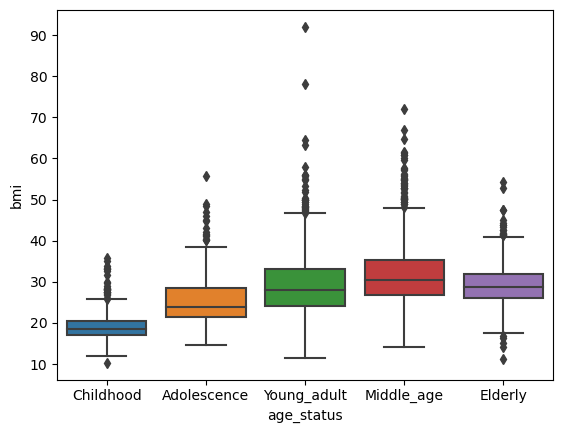

In [44]:
age_status_boxplot = sns.boxplot(data=stroke_train_full, x="age_status", y="bmi")
plt.show(age_status_boxplot)

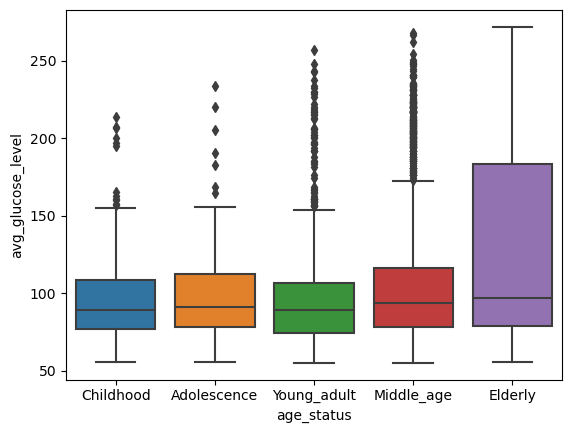

In [45]:
sns.boxplot(data=stroke_train_full, x="age_status", y="avg_glucose_level")
plt.show()

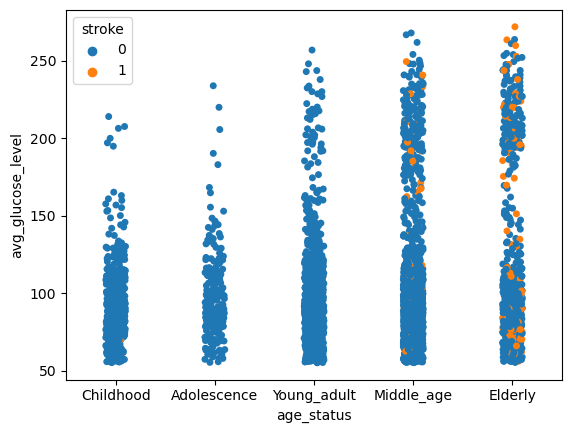

In [46]:
sns.stripplot(data=stroke_train_full, x="age_status", y="avg_glucose_level", 
            hue = "stroke")
plt.show()

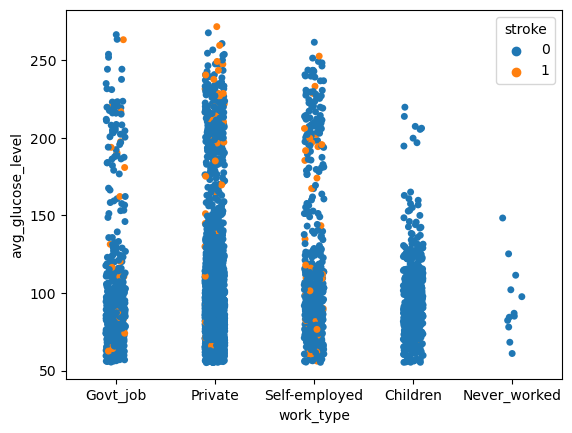

In [47]:
sns.stripplot(data=stroke_train_full, x="work_type", y="avg_glucose_level", 
            hue = "stroke")
plt.show()

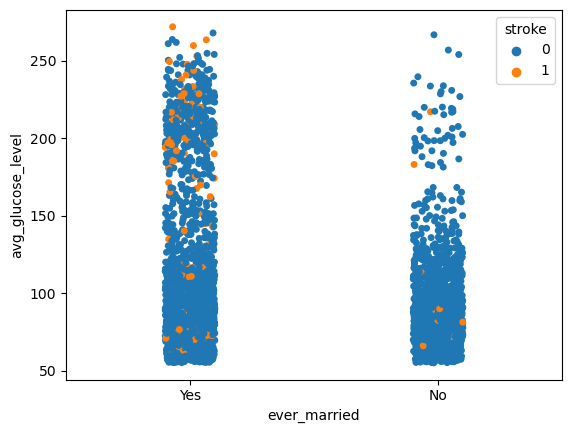

In [48]:
sns.stripplot(data=stroke_train_full, x="ever_married", y="avg_glucose_level", 
            hue = "stroke")
plt.show()

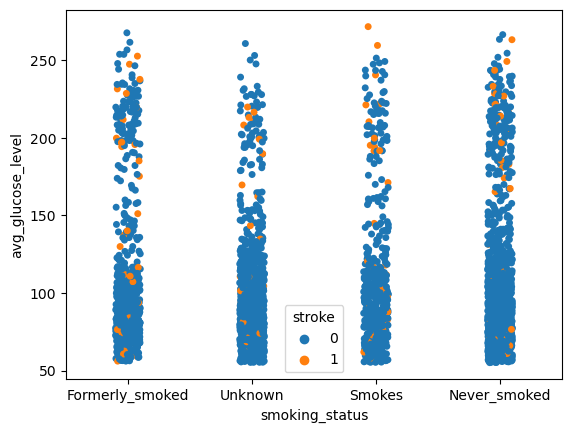

In [49]:
sns.stripplot(data=stroke_train_full, x="smoking_status", y="avg_glucose_level", 
            hue = "stroke")
plt.show() 

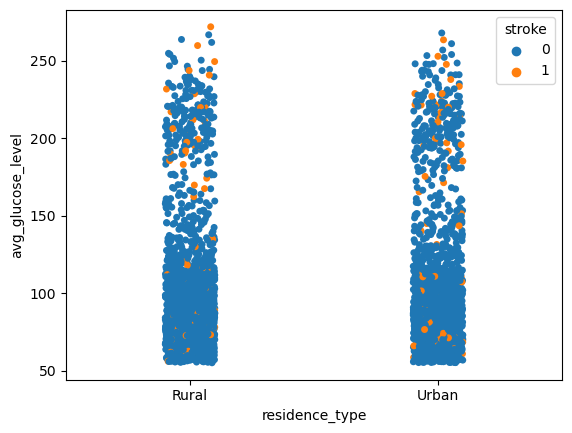

In [50]:
sns.stripplot(data=stroke_train_full, x="residence_type", y="avg_glucose_level", 
            hue = "stroke")
plt.show() 

In [51]:
stroke_train_full.groupby(["age_status"]).agg(bmi_mean = ("bmi", "mean"),
                                      bmi_median = ("bmi", "median"),
                                      bmi_std = ("bmi", "std"))

,bmi_mean,bmi_median,bmi_std
age_status,,,
Childhood,19.268825,18.60,3.704764
Adolescence,25.832629,23.75,7.013804
Young_adult,29.570138,27.90,7.810395
Middle_age,31.661701,30.50,7.347783
Elderly,29.175628,28.70,5.343083


In [52]:
print(stroke_train_full.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3577 entries, 2226 to 5052
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             3577 non-null   object  
 1   age                3577 non-null   float64 
 2   hypertension       3577 non-null   int64   
 3   heart_disease      3577 non-null   int64   
 4   ever_married       3577 non-null   object  
 5   work_type          3577 non-null   object  
 6   residence_type     3577 non-null   object  
 7   avg_glucose_level  3577 non-null   float64 
 8   bmi                3577 non-null   float64 
 9   smoking_status     3577 non-null   object  
 10  stroke             3577 non-null   int64   
 11  age_status         3577 non-null   category
 12  glucose_range      3577 non-null   category
 13  bmi_range          3577 non-null   category
dtypes: category(3), float64(3), int64(3), object(5)
memory usage: 346.3+ KB
None


In [53]:
stroke_train_full.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_status           0
glucose_range        0
bmi_range            0
dtype: int64

In [54]:
stroke_train_full[numerics].corrwith(stroke_train_full.stroke)

age                  0.246029
avg_glucose_level    0.123389
bmi                  0.032153
dtype: float64

Text(0, 0.5, 'Count')

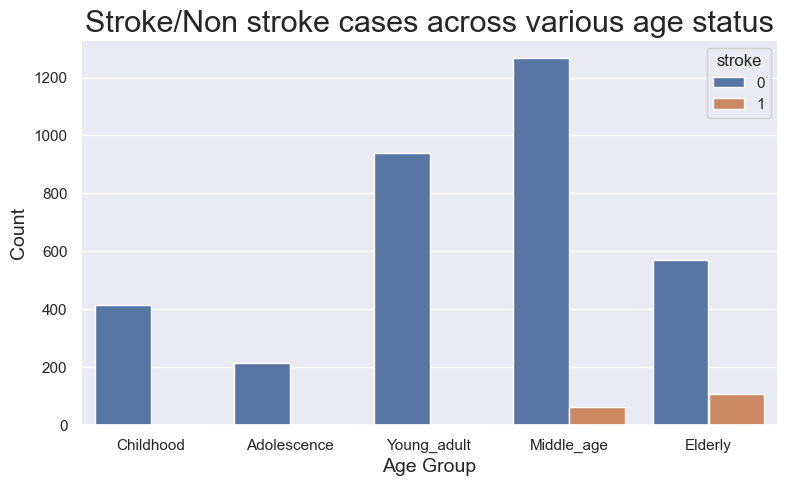

In [55]:
sns.set(rc={'figure.figsize':(9,5)})
ax = sns.countplot(x='age_status',hue='stroke',data=stroke_train_full)
ax.set_title('Stroke/Non stroke cases across various age status').set_fontsize(22)
ax.set_xlabel('Age Group',fontsize=14)
ax.set_ylabel('Count',fontsize=14)

Text(0, 0.5, 'Count')

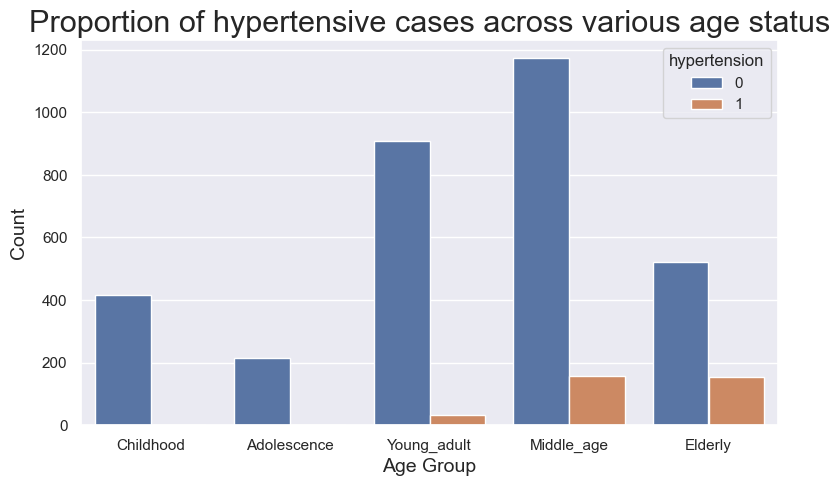

In [56]:
sns.set(rc={'figure.figsize':(9,5)})
ax = sns.countplot(x='age_status',hue='hypertension',data=stroke_train_full)
ax.set_title('Proportion of hypertensive cases across various age status').set_fontsize(22)
ax.set_xlabel('Age Group',fontsize=14)
ax.set_ylabel('Count',fontsize=14)

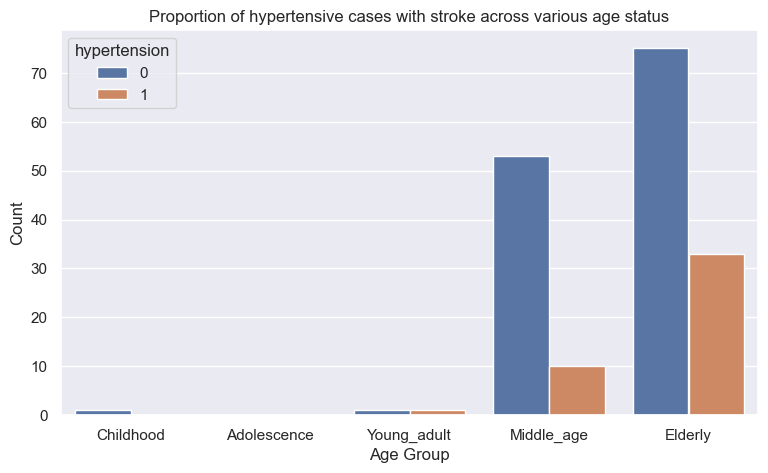

In [57]:
ax = sns.countplot(x='age_status',hue='hypertension',data=stroke_train_full[stroke_train_full["stroke"] == 1])
ax.set_title('Proportion of hypertensive cases with stroke across various age status')
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
plt.show()

<Axes: xlabel='stroke', ylabel='age'>

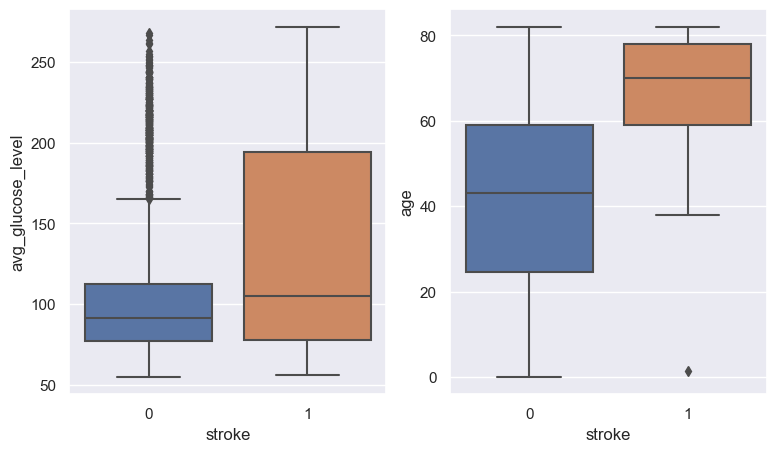

In [58]:
fig, axs = plt.subplots(ncols=2)
sns.boxplot(y="avg_glucose_level", x="stroke", data=stroke_train_full, ax=axs[0])
#sns.boxplot(y="bmi", x="stroke", data=stroke_train_full, ax=axs[1])
sns.boxplot(y="age", x="stroke", data=stroke_train_full, ax=axs[1])

<Axes: >

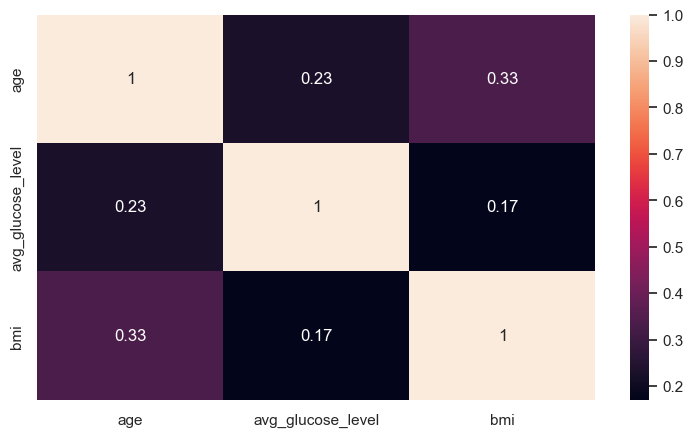

In [59]:
num_stroke_corr = stroke_train_full[numerics].corr()
sns.heatmap(num_stroke_corr, annot = True)

C:\Users\jidep\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


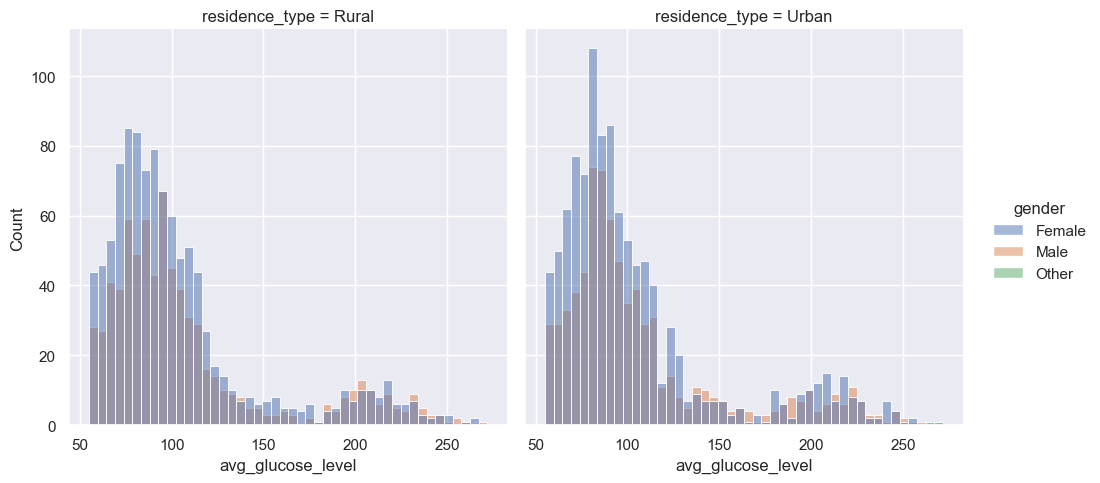

In [60]:
sns.displot(data=stroke_train_full, x="avg_glucose_level", hue="gender", col="residence_type")

## 4.0 Data Modeling
[Top](#Contents) 
[Feature-Engineering](#4.1-Feature-Engineering)  
[Candidate-Models](#4.2-Evaluation-of-Candidate-Models)  
[Model Tuning](#4.3-Tuning-Candidate-Models-and-Streamlining-the-Approach)


### 4.1 Feature Engineering

From the insights gained during exploratory data analysis, the bins in the age_bin feature is reduced to three natural age group to improve learning from the data.    
Similarly, the categories in the smoking_status and work_type are both reduced to three categories as shown in the remap_smoking and remap_work_type dictionaries. 

In [61]:
dev_stage = ["Young", "Middle_age", "Elderly"]
age_bin = [-np.inf, 40, 65, np.inf]


remap_smoking = {'Smokes': 'Smoking_history', 'Formerly_smoked': 'Smoking_history', \
                 'Never_smoked': 'Smoking_never', 'Unknown': 'Smoking_uncertain'}

remap_work_type = {'Private': 'Private_sector', 'Self-employed': 'Non_private_sector', \
                   'Govt_job': 'Non_private_sector', 'Children': 'Dependent', 'Never_worked': 'Dependent'}   

In [62]:
       
def remap_work_smoking(dframe):
    """creating new columns from the smoking_status and work_type columns
       Each new column is streamlined by merging defined categories"""
    dframe["smoking_history"] = dframe["smoking_status"].map(remap_smoking)
    dframe["work_segment"] = dframe["work_type"].map(remap_work_type)
    return dframe

#
#def data_prepare_initial(dframe):
#    clean_formatting(dframe)
#    gen_features(dframe)
#    resolve_missing_bmi(dframe)
#    remap_work_smoking(dframe)

def combined_dataprep_interface(dframe):
    """recodes columns with object and integers (0 and 1) explicitly as category datatypes
       and returns a tuple, each a dataframe, of the features and the target variable"""
        
    numeric_cols = ["float"]
    numerics = get_the_data_types(dframe,numeric_cols)
    cat_cols = ["object", "int"]
    categorical = get_the_data_types(dframe,cat_cols)

    for col in categorical:
        dframe[col] = dframe[col].astype('category')

    dframe['ever_married'] = dframe['ever_married'].cat.rename_categories({'Yes': 'Married', 'No': 'Single'})
    target = dframe.pop('stroke')
    return dframe, target

def column_trns_variables(clean_dframe):
    """returns a tuple, each a list, of the categorical and numerical columns respectively
       expected function argument is the features dataframe"""
    num_vars = get_the_data_types(clean_dframe,["float64"])
    enc_vars = get_the_data_types(clean_dframe,["int64","object","category", "bool"])

    cat_idx = []
    num_idx = []
    for colname in enc_vars:
        idx = clean_dframe.columns.get_loc(colname)
        cat_idx.append(idx)
        num_idx = []
    for colname in num_vars:
        idx = clean_dframe.columns.get_loc(colname)
        num_idx.append(idx)
    return cat_idx, num_idx

In [63]:
train_df_copy = stroke_train_df.copy(deep=True)

In [64]:
clean_formatting(stroke_train_df)
gen_features(stroke_train_df)
resolve_missing_bmi(stroke_train_df)
remap_work_smoking(stroke_train_df)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_status,glucose_range,bmi_range,smoking_history,work_segment
2226,35602,Female,52.0,0,0,Yes,Govt_job,Rural,107.84,22.0,Formerly_smoked,0,Middle_age,Normal,Midway,Smoking_history,Non_private_sector
3927,56137,Female,62.0,0,0,Yes,Private,Urban,88.32,36.3,Unknown,0,Middle_age,Normal,Obese,Smoking_uncertain,Private_sector
3358,14063,Male,81.0,0,1,No,Self-employed,Rural,95.49,29.4,Unknown,0,Elderly,Normal,Midway,Smoking_uncertain,Non_private_sector
4152,12857,Male,55.0,0,0,Yes,Self-employed,Rural,73.57,28.0,Smokes,0,Middle_age,Normal,Midway,Smoking_history,Non_private_sector
4866,5875,Female,37.0,0,0,Yes,Private,Urban,103.66,36.1,Smokes,0,Young,Normal,Obese,Smoking_history,Private_sector
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,67217,Female,45.0,0,0,Yes,Private,Urban,92.86,35.1,Formerly_smoked,0,Middle_age,Normal,Obese,Smoking_history,Private_sector
461,34376,Female,16.0,0,0,No,Children,Rural,113.47,19.5,Unknown,0,Young,Normal,Midway,Smoking_uncertain,Dependent
1052,10752,Female,61.0,0,0,Yes,Private,Rural,78.65,36.2,Formerly_smoked,0,Middle_age,Normal,Obese,Smoking_history,Private_sector
152,32503,Female,80.0,0,0,Yes,Self-employed,Urban,76.57,34.1,Never_smoked,1,Elderly,Normal,Midway,Smoking_never,Non_private_sector


In [65]:
stroke_train_df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_status', 'glucose_range', 'bmi_range',
       'smoking_history', 'work_segment'],
      dtype='object')

In [66]:
stroke_train_df = stroke_train_df.drop(stroke_train_df[stroke_train_df['gender'] == "Other"].index)

In [67]:
print(stroke_train_df['smoking_status'].value_counts())
print("==========================================")
print(stroke_train_df['smoking_history'].value_counts())

smoking_status
Never_smoked       1327
Unknown            1084
Formerly_smoked     630
Smokes              535
Name: count, dtype: int64
smoking_history
Smoking_never        1327
Smoking_history      1165
Smoking_uncertain    1084
Name: count, dtype: int64


In [68]:
print(stroke_train_df['work_type'].value_counts())
print("==========================================")
print(stroke_train_df['work_segment'].value_counts())

work_type
Private          2043
Self-employed     589
Children          481
Govt_job          451
Never_worked       12
Name: count, dtype: int64
work_segment
Private_sector        2043
Non_private_sector    1040
Dependent              493
Name: count, dtype: int64


In [69]:
stroke_train_df = stroke_train_df.drop('smoking_status', axis=1)
stroke_train_df = stroke_train_df.drop('work_type', axis=1)
stroke_train_df = stroke_train_df.drop('id', axis=1)

In [70]:
stroke_train_df['gender'].value_counts()

gender
Female    2093
Male      1483
Name: count, dtype: int64

In [71]:
X, y = combined_dataprep_interface(stroke_train_df)

In [72]:
y.shape

(3576,)

In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3576 entries, 2226 to 5052
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             3576 non-null   category
 1   age                3576 non-null   float64 
 2   hypertension       3576 non-null   category
 3   heart_disease      3576 non-null   category
 4   ever_married       3576 non-null   category
 5   residence_type     3576 non-null   category
 6   avg_glucose_level  3576 non-null   float64 
 7   bmi                3576 non-null   float64 
 8   age_status         3576 non-null   category
 9   glucose_range      3576 non-null   category
 10  bmi_range          3576 non-null   category
 11  smoking_history    3576 non-null   category
 12  work_segment       3576 non-null   category
dtypes: category(10), float64(3)
memory usage: 147.9 KB


### 4.2 Evaluation of Candidate Models
[4.0](#4.0-Data-Modeling)

In [74]:
cat_idx, num_idx = column_trns_variables(X)

In [75]:
print(num_idx)
print(cat_idx)

[1, 6, 7]
[0, 2, 3, 4, 5, 8, 9, 10, 11, 12]


In [76]:
numeric_vars = num_idx
categorical_vars = cat_idx

simple_smote = SMOTE(sampling_strategy=1.0, random_state=rng_val)

ohe = OneHotEncoder(categories = 'auto', dtype = 'int32', drop = None, handle_unknown = "ignore") #sparse_output=True by default

ohe_processor = Pipeline(steps =
        [('cat', OneHotEncoder(categories = 'auto', handle_unknown = "ignore"))]
)

numeric_processor = Pipeline(steps =
        [('num', QuantileTransformer(n_quantiles=10, random_state=rng_val))],
)

col_processor = ColumnTransformer(transformers =
        [('c', ohe_processor, cat_idx),
         ('n', numeric_processor, num_idx), 
    ]
)

In [77]:
X_new = col_processor.fit_transform(X)
print(X_new.shape)

(3576, 28)


Here we go through an additional process of splitting the transformed training dataset into a training and test set. 
The training set is both SMOTE transformed and further splitted into another set of "SMOTED" sub-training and "SMOTED" sub-test dataset. 
  
Performance of candidate classifiers are evaluated as follows:
* Step 1: They are trained on the SMOTE transformed sub-training dataset
* Step 2: Performance metrics on trained model is evaluated on SMOTED sub-test dataset
* Step 3: Performance is evaluated on the "non-SMOTED" test to mimic a scenario of "exposure to novel data"
* Step 4: Candidate classifier for modeling are selected from 
        favorable performance in Step 3, using Matthews Correlation Coefficient (MCC)

In [78]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.20, random_state=rng_val)

In [79]:
print(X_new_train.shape, X_new_test.shape)
print(y_new_train.shape, y_new_test.shape)
print(Counter(y_new_train))
print(Counter(y_new_test))

(2860, 28) (716, 28)
(2860,) (716,)
Counter({0: 2723, 1: 137})
Counter({0: 679, 1: 37})


In [80]:
X_smote, y_smote = simple_smote.fit_resample(X_new_train,y_new_train)

In [81]:
print(X_smote.shape, y_smote.shape)
print(Counter(y_smote))

(5446, 28) (5446,)
Counter({0: 2723, 1: 2723})


In [82]:
X_train_sm_1, X_test_sm_1, y_train_sm_1, y_test_sm_1 = train_test_split(X_smote, y_smote,\
                                                        test_size= 0.3, random_state=rng_val)

In [83]:
print(X_train_sm_1.shape, X_test_sm_1.shape)
print(y_train_sm_1.shape, y_test_sm_1.shape)
print(Counter(y_train_sm_1))
print(Counter(y_test_sm_1))

(3812, 28) (1634, 28)
(3812,) (1634,)
Counter({1: 1922, 0: 1890})
Counter({0: 833, 1: 801})


In [84]:
models = {"LogisticRegression": LogisticRegression(max_iter = 4000, random_state = rng_val), "KNN": KNeighborsClassifier(),\
          "DecisionTree": DecisionTreeClassifier(random_state = rng_val), "RandomForest": RandomForestClassifier(min_samples_leaf=3, random_state = rng_val),\
          "SupportVectorMachine": SVC(kernel="rbf", random_state= rng_val)}

In [85]:
def fit_models(model_dict, train_x, train_y):
    """takes training dataframe and a dictionary of models and fits each"""
    models = list(model_dict)
    for name in models:
        model_dict[name] = model_dict[name].fit(train_x, train_y)

def pred_eval_model(model_dict, test_x, test_y):
    """takes a dictionary of fitted models and test dataframes, and returns a tuple of dictionaries for
       classification report and matthews correlation coefficient"""
    eval_rpt = {}
    mcc_dict = {}
    pred_val = {}
    models = list(model_dict)
    for name in models:
        pred_val[name] = model_dict[name].predict(test_x)
        eval_rpt[name] = classification_report_imbalanced(test_y, pred_val[name], output_dict=False)
        mcc_dict[name] = matthews_corrcoef(test_y, pred_val[name])
    return eval_rpt, mcc_dict

def dict_prf_rpt(model_dict,eval_rpt, mcc_dict):
    """takes a dictionary each of fitted models, classification report and matthews correlation coefficient
       and prints for each model the associated classification report and matthews correlation coefficient"""
    models = list(model_dict)
    for name in models:
        print("{}:".format(name))
        print("++++++++++++++++++++++++++++++++++")
        print(f"MCC value is: {mcc_dict[name]:.3f}")
        print("==================================================================================")
        print(eval_rpt[name])

In [86]:
# The performance report below is based on fitting with SMOTE data and evaluating on SMOTE data
fit_models(models, X_train_sm_1, y_train_sm_1)
eval_rpt, mcc_dict = pred_eval_model(models, X_test_sm_1, y_test_sm_1)
dict_prf_rpt(models,eval_rpt, mcc_dict)

LogisticRegression:
++++++++++++++++++++++++++++++++++
MCC value is: 0.574
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.71      0.86      0.77      0.78      0.60       833
          1       0.74      0.86      0.71      0.79      0.78      0.62       801

avg / total       0.79      0.78      0.79      0.78      0.78      0.61      1634

KNN:
++++++++++++++++++++++++++++++++++
MCC value is: 0.811
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.81      0.99      0.89      0.90      0.79       833
          1       0.83      0.99      0.81      0.91      0.90      0.82       801

avg / total       0.91      0.90      0.90      0.90      0.90      0.80      1634

DecisionTree:
++++++++++++++++++++++++++++++++++
MCC value is: 0.851
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.92      0.94

In [87]:
# The performance report below is based on fitting with SMOTE data and evaluating on non-SMOTE data

eval_rpt, mcc_dict = pred_eval_model(models, X_new_test, y_new_test)
dict_prf_rpt(models, eval_rpt, mcc_dict)

LogisticRegression:
++++++++++++++++++++++++++++++++++
MCC value is: 0.245
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.72      0.78      0.83      0.75      0.56       679
          1       0.13      0.78      0.72      0.23      0.75      0.57        37

avg / total       0.94      0.73      0.78      0.80      0.75      0.56       716

KNN:
++++++++++++++++++++++++++++++++++
MCC value is: 0.083
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.82      0.32      0.88      0.52      0.28       679
          1       0.09      0.32      0.82      0.14      0.52      0.25        37

avg / total       0.91      0.80      0.35      0.85      0.52      0.28       716

DecisionTree:
++++++++++++++++++++++++++++++++++
MCC value is: 0.085
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.92      0.19

### 4.3 Tuning Candidate Models and Streamlining the Approach
[4.0](#4.0-Data-Modeling)

In this section, we focus our attention on the top two performing classifiers and tune thier hyper parameters.  
Our intent is to evaluate their performance and the resilience when evaluated with previously unseen data  

In [88]:
process_cols = ColumnTransformer(transformers =
        [('cat', ohe, categorical_vars), 
        ('num', QuantileTransformer(n_quantiles=10, random_state=rng_val), numeric_vars)],remainder='passthrough'
)

In [89]:
svm_pipe = Pipeline(steps=[("preprocessor", col_processor),
                           ("s", SMOTE(sampling_strategy=1.0)),
                           ("svm", SVC(kernel="rbf", random_state=None) )
])

In [90]:
parameter_grid_svm = {'svm__C':[0.01, 0.1, 1.0, 5, 10, 50], 
                  'svm__gamma': ['scale', 'auto']
            }

svm_search = GridSearchCV(estimator = svm_pipe, param_grid = parameter_grid_svm,
                scoring= "matthews_corrcoef", cv = KFold(5, random_state=rng_val, shuffle=True), refit=True, return_train_score = True, n_jobs = 12)

svm_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('c',
                                                                         Pipeline(steps=[('cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12]),
                                                                        ('n',
                                                                         Pipeline(steps=[('num',
                                                                                          QuantileTransformer(n_quantiles=10,
                                                                                                              random_state=42))]),
                                                                         [1, 6,
                                                                          7])])),
                                       ('s', SMOTE(sampling_strategy=1.0)),
                                       ('svm', SVC())]),
             n_jobs=12,
             param_grid={'svm__C': [0.01, 0.1, 1.0, 5, 10, 50],
                         'svm__gamma': ['scale', 'auto']},
             return_train_score=True, scoring='matthews_corrcoef')

In [91]:
print(svm_search.best_score_)
print(svm_search.best_params_)

0.24461243811222388
{'svm__C': 1.0, 'svm__gamma': 'auto'}


In [92]:
svc_best_estimator = svm_search.best_estimator_

In [93]:
index = []
#scores = {"Balanced accuracy": []} #'Accuracy': [],
#scoring = ["accuracy", "balanced_accuracy"]

grid = [
        {'estim__penalty': ['l1'], 'estim__solver': ['liblinear', 'saga']},
        {'estim__penalty': ['l2'], 'estim__solver': ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear', 'newton-cholesky']},
        {'estim__penalty': ['elasticnet'], 'estim__solver': ['saga'], 'estim__l1_ratio': [0.1, 0.15, 0.30, 0.6, 0.75, 0.9]},
        {'estim__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
]

In [94]:
model_reg = LogisticRegression(max_iter=4000, random_state=rng_val)

In [95]:
lr_pipe = Pipeline(steps=[("preprocessor", col_processor),
                           ("s", SMOTE(sampling_strategy=1.0)),
                           ("estim", model_reg )
])

In [96]:
logreg_search_cv = GridSearchCV(lr_pipe, param_grid = grid, scoring="matthews_corrcoef", cv = KFold(5, random_state=None, shuffle=True), refit=True, return_train_score = True)

In [97]:
logreg_search_cv.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('c',
                                                                         Pipeline(steps=[('cat',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12]),
                                                                        ('n',
                                                                         Pipeline(steps=[('num',
                                                                                          QuantileTransformer(n_quantiles=10,
                                                                                                              random_state=42))]),
                                                                         [1, 6,
                                                                          7])])),
                                       ('s', SMOTE(sampling_...
                          'estim__solver': ['liblinear', 'saga']},
                         {'estim__penalty': ['l2'],
                          'estim__solver': ['newton-cg', 'sag', 'saga', 'lbfgs',
                                            'liblinear', 'newton-cholesky']},
                         {'estim__l1_ratio': [0.1, 0.15, 0.3, 0.6, 0.75, 0.9],
                          'estim__penalty': ['elasticnet'],
                          'estim__solver': ['saga']},
                         {'estim__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                       1000.0]}],
             return_train_score=True, scoring='matthews_corrcoef')

In [98]:
print(logreg_search_cv.best_score_)
print("+++++++++++++++++++++++++++++")
print(logreg_search_cv.best_params_)
print("+++++++++++++++++++++++++++++")
print(logreg_search_cv.best_estimator_)

0.26408167471851274
+++++++++++++++++++++++++++++
{'estim__l1_ratio': 0.3, 'estim__penalty': 'elasticnet', 'estim__solver': 'saga'}
+++++++++++++++++++++++++++++
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('c',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 2, 3, 4, 5, 8, 9, 10, 11,
                                                   12]),
                                                 ('n',
                                                  Pipeline(steps=[('num',
                                                                   QuantileTransformer(n_quantiles=10,
                                                                                       random_state=42))]),
                                                  [1, 6, 7])])),
                ('s', SM

In [99]:
logreg_best_estimator = logreg_search_cv.best_estimator_

In [100]:
stroke_val_copy = stroke_val_df.copy(deep=True)
clean_formatting(stroke_val_copy)
gen_features(stroke_val_copy)
resolve_missing_bmi(stroke_val_copy)
remap_work_smoking(stroke_val_copy)
X_val, y_val = combined_dataprep_interface(stroke_val_copy)

In [101]:
best_two_models = {'SupportVectorMachines': svc_best_estimator ,'LogisticRegression':logreg_best_estimator}

In [102]:
fit_models(best_two_models, X, y)
eval_rpt_2, mcc_dict_2 = pred_eval_model(best_two_models, X_val, y_val)
dict_prf_rpt(best_two_models, eval_rpt_2, mcc_dict_2)

SupportVectorMachines:
++++++++++++++++++++++++++++++++++
MCC value is: 0.236
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.76      0.73      0.86      0.74      0.55       729
          1       0.13      0.73      0.76      0.22      0.74      0.55        37

avg / total       0.94      0.76      0.73      0.82      0.74      0.55       766

LogisticRegression:
++++++++++++++++++++++++++++++++++
MCC value is: 0.243
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.71      0.81      0.83      0.76      0.57       729
          1       0.13      0.81      0.71      0.22      0.76      0.58        37

avg / total       0.95      0.72      0.81      0.80      0.76      0.57       766



## 5.0 Final Model
[top](#Contents)

In [103]:
stroke_concat_df = pd.concat([train_df_copy, stroke_val_df], axis=0)

In [104]:
stroke_concat_df.info(gen_features)

<class 'pandas.core.frame.DataFrame'>
Index: 4343 entries, 2226 to 4226
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4343 non-null   int64  
 1   gender             4343 non-null   object 
 2   age                4343 non-null   float64
 3   hypertension       4343 non-null   int64  
 4   heart_disease      4343 non-null   int64  
 5   ever_married       4343 non-null   object 
 6   work_type          4343 non-null   object 
 7   Residence_type     4343 non-null   object 
 8   avg_glucose_level  4343 non-null   float64
 9   bmi                4164 non-null   float64
 10  smoking_status     4343 non-null   object 
 11  stroke             4343 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 441.1+ KB


In [105]:
clean_formatting(stroke_concat_df)
gen_features(stroke_concat_df)
resolve_missing_bmi(stroke_concat_df)
remap_work_smoking(stroke_concat_df)

stroke_concat_df = stroke_concat_df.drop('smoking_status', axis=1)
stroke_concat_df = stroke_concat_df.drop('work_type', axis=1)
stroke_concat_df = stroke_concat_df.drop('id', axis=1)
stroke_concat_df = stroke_concat_df.drop(stroke_concat_df[stroke_concat_df['gender'] == "Other"].index)

X_full_df, y_full_df = combined_dataprep_interface(stroke_concat_df)
cat_idx, num_idx = column_trns_variables(stroke_concat_df)

In [106]:
from sklearn.preprocessing import QuantileTransformer

ohe_process = Pipeline(steps =
        [('cat', OneHotEncoder(categories = 'auto', handle_unknown = "ignore"))]
)

num_process = Pipeline(steps =
        [('num', QuantileTransformer(n_quantiles=10, random_state=rng_val))],
)

feature_prep = ColumnTransformer(transformers =
        [('c', ohe_process, cat_idx),
         ('n', num_process, num_idx), 
    ]
)


In [107]:
chosen_model = LogisticRegression(C=0.01, max_iter=4000, n_jobs=8, random_state=None)

In [108]:
final_model =  Pipeline(steps=[("preprocessor", feature_prep),
                           ("s", SMOTE(sampling_strategy=1.0)),
                           ("rfe", RFECV(chosen_model, cv=KFold(5, random_state=rng_val, shuffle=True), step=1, min_features_to_select=1, verbose=0, scoring= "matthews_corrcoef"))
])


In [109]:
my_scores = cross_validate(final_model, X_full_df, y_full_df, return_train_score=True, cv=5)

In [110]:
my_scores_df = pd.DataFrame.from_dict(my_scores).agg("mean")
my_scores_df

fit_time       31.941592
score_time      0.006754
test_score      0.747124
train_score     0.750115
dtype: float64

In [111]:
feature_prep.fit(X_full_df, y_full_df)
final_model.fit(X_full_df, y_full_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('c',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 2, 3, 4, 5, 8, 9, 10, 11,
                                                   12]),
                                                 ('n',
                                                  Pipeline(steps=[('num',
                                                                   QuantileTransformer(n_quantiles=10,
                                                                                       random_state=42))]),
                                                  [1, 6, 7])])),
                ('s', SMOTE(sampling_strategy=1.0)),
                ('rfe',
                 RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=LogisticRegression(C=0.01, max_iter=4000,
                                                    n_jobs=8),
                       scoring='matthews_corrcoef'))])

In [112]:
feature_names = col_processor.get_feature_names_out()

In [113]:
feature_num = final_model.named_steps["rfe"].n_features_
feature_rank = final_model.named_steps["rfe"].ranking_
feature_support = final_model.named_steps["rfe"].support_
features_selected = feature_names[feature_support]
#print(feature_names[feature_support])
features_selected

array(['c__hypertension_0', 'c__heart_disease_0', 'c__heart_disease_1',
       'c__ever_married_Married', 'c__ever_married_Single',
       'c__age_status_Elderly', 'c__age_status_Young',
       'c__glucose_range_Hyper', 'c__glucose_range_Hypo',
       'c__bmi_range_Midway', 'c__smoking_history_Smoking_history',
       'c__smoking_history_Smoking_never', 'n__age',
       'n__avg_glucose_level', 'n__bmi'], dtype=object)

In [114]:
clean_formatting(stroke_test_df)
gen_features(stroke_test_df)
resolve_missing_bmi(stroke_test_df)
remap_work_smoking(stroke_test_df)

stroke_test_df = stroke_test_df.drop('smoking_status', axis=1)
stroke_test_df = stroke_test_df.drop('work_type', axis=1)
stroke_test_df = stroke_test_df.drop('id', axis=1)
stroke_test_df = stroke_test_df.drop(stroke_test_df[stroke_test_df['gender'] == "Other"].index)

X_test, y_test = combined_dataprep_interface(stroke_test_df)

In [115]:
final_model_dict = {"final_model":final_model}

In [116]:
eval_rpt_final, mcc_dict_final = pred_eval_model(final_model_dict, X_test, y_test)
dict_prf_rpt(final_model_dict, eval_rpt_final, mcc_dict_final)

final_model:
++++++++++++++++++++++++++++++++++
MCC value is: 0.257
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.73      0.82      0.84      0.77      0.59       729
          1       0.13      0.82      0.73      0.23      0.77      0.60        38

avg / total       0.94      0.73      0.81      0.81      0.77      0.59       767



## 6.0 Model Deployment
[top](#Contents)

In [117]:
#Prepare full dataset ready for being trained on the selected final model
clean_formatting(stroke_df)
gen_features(stroke_df)
resolve_missing_bmi(stroke_df)
remap_work_smoking(stroke_df)

stroke_df = stroke_df.drop('smoking_status', axis=1)
stroke_df = stroke_df.drop('work_type', axis=1)
stroke_df = stroke_df.drop('id', axis=1)
stroke_df = stroke_df.drop(stroke_df[stroke_df['gender'] == "Other"].index)

X_feature_df, y_feature_df = combined_dataprep_interface(stroke_df)

In [118]:
feature_prep.fit(X_feature_df, y_feature_df)
final_model.fit(X_feature_df, y_feature_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('c',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 2, 3, 4, 5, 8, 9, 10, 11,
                                                   12]),
                                                 ('n',
                                                  Pipeline(steps=[('num',
                                                                   QuantileTransformer(n_quantiles=10,
                                                                                       random_state=42))]),
                                                  [1, 6, 7])])),
                ('s', SMOTE(sampling_strategy=1.0)),
                ('rfe',
                 RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=LogisticRegression(C=0.01, max_iter=4000,
                                                    n_jobs=8),
                       scoring='matthews_corrcoef'))])

In [119]:
#Remove the docstring if you would like to download the pickle file
"""import pickle
 
with open('stroke-model.bin', 'wb') as f_out:
    pickle.dump(final_model, f_out)
"""

"import pickle\n \nwith open('stroke-model.bin', 'wb') as f_out:\n    pickle.dump(final_model, f_out)\n"